<a href="https://colab.research.google.com/github/rodrigorissettoterra/MovieRecommenderSystem/blob/main/Sistema_de_recomenda%C3%A7%C3%A3o_de_filmes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparando o ambiente

## Bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

## Carregando os dataframes

In [2]:
# Carrega os arquivos CSV
movies = pd.read_csv('https://raw.githubusercontent.com/rodrigorissettoterra/MovieRecommenderSystem/refs/heads/main/movies.csv')
genres = pd.read_csv('https://raw.githubusercontent.com/rodrigorissettoterra/MovieRecommenderSystem/refs/heads/main/genres.csv')

In [3]:
movies.head()

,Unnamed: 0,id,original_title,overview,genre_ids
0,0,238,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...","[18, 80]"
1,1,278,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,"[18, 80]"
2,2,240,The Godfather Part II,In the continuing saga of the Corleone crime f...,"[18, 80]"
3,3,424,Schindler's List,The true story of how businessman Oskar Schind...,"[18, 36, 10752]"
4,4,19404,दिलवाले दुल्हनिया ले जायेंगे,"Raj is a rich, carefree, happy-go-lucky second...","[35, 18, 10749]"


In [4]:
genres.head()

,Unnamed: 0,id,name
0,0,28,Action
1,1,12,Adventure
2,2,16,Animation
3,3,35,Comedy
4,4,80,Crime


In [5]:
print("O dataset movie.csv possui:",movies.shape[0],"linhas e",movies.shape[1],"colunas.")
print("O dataset genre.csv possui:",genres.shape[0],"linhas e",genres.shape[1],"colunas.")

O dataset movie.csv possui: 9007 linhas e 5 colunas.
O dataset genre.csv possui: 19 linhas e 3 colunas.


## Pequenas alterações

In [6]:
# Remover colunas desnecessárias
movies = movies.drop(columns=['Unnamed: 0', 'overview'])
genres = genres.drop(columns=['Unnamed: 0'])

In [7]:
# Renomear colunas do DataFrame de filmes
movies = movies.rename(columns={'id': 'movieId', 'original_title': 'title'})

In [8]:
# Converter a coluna genre_ids de string para lista
movies['genre_ids'] = movies['genre_ids'].apply(ast.literal_eval)

# Explodir a lista de gêneros para criar uma linha por gênero
movies_exploded = movies.explode('genre_ids')

## União dos dataframes

In [9]:
# Realizar o merge com o DataFrame de gêneros
merged = movies_exploded.merge(genres, left_on='genre_ids', right_on='id', how='left')

# Tratar valores nulos que podem surgir do merge
merged['name'] = merged['name'].fillna('Unknown')

In [10]:
# Agrupar por filme e concatenar os gêneros com '|'
movies2 = merged.groupby(['movieId', 'title'])['name'] \
                 .apply(lambda x: ' '.join(sorted(set(x)))) \
                 .reset_index()

# Renomear a coluna final de gêneros
movies = movies2.rename(columns={'name': 'genres'})

# Exibir o resultado final
movies.head()

,movieId,title,genres
0,3,Varjoja paratiisissa,Comedy Drama Romance
1,5,Four Rooms,Comedy
2,6,Judgment Night,Action Crime Thriller
3,11,Star Wars,Action Adventure Science Fiction
4,12,Finding Nemo,Animation Family


In [11]:
print("O dataset movie.csv (após as alterações) possui:",movies.shape[0],"linhas e",movies.shape[1],"colunas.")

O dataset movie.csv (após as alterações) possui: 9004 linhas e 3 colunas.


## Verificação de itens vazios

In [12]:
movies.isnull().sum()

,0
movieId,0
title,0
genres,0


A base de dados não possui nenhum item NULL

## Explorando gêneros dos filmes

In [13]:
# Contabilizar a quantidade de filmes por gênero
genre_counts = merged['name'].value_counts().reset_index()
genre_counts.columns = ['genre', 'movie_count']
genre_counts

,genre,movie_count
0,Drama,3959
1,Comedy,3260
2,Thriller,2460
3,Action,2114
4,Adventure,1521
5,Romance,1508
6,Crime,1353
7,Horror,1303
8,Science Fiction,1100
9,Family,1040


**Observação:** Neste dataframe, filmes podem ter mais de um gênero.

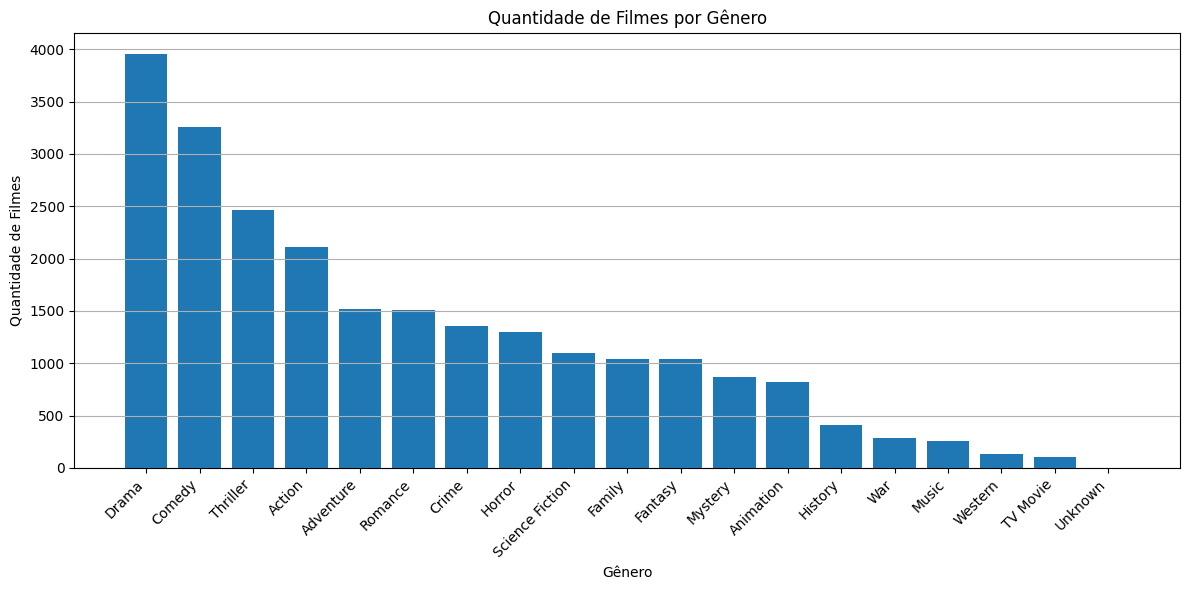

In [14]:
# Ordenar o DataFrame pelo número de filmes em ordem decrescente
genre_counts_sorted = genre_counts.sort_values(by='movie_count', ascending=False)

# Plotar o gráfico de barras com o dataframe genre_counts
plt.figure(figsize=(12, 6))
plt.bar(genre_counts_sorted['genre'], genre_counts_sorted['movie_count'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Gênero')
plt.ylabel('Quantidade de Filmes')
plt.title('Quantidade de Filmes por Gênero')
plt.tight_layout()
plt.grid(axis='y')

plt.show()

## Term frequency e Inverse document frequency (tf-idf)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
tfidf_vector = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vector.fit_transform(movies['genres'])

In [17]:
from sklearn.metrics.pairwise import linear_kernel

In [18]:
sim_matrix = linear_kernel(tfidf_matrix, tfidf_matrix)

## Definindo a função de recomendação

In [19]:
def get_title_from_index (index):
  return movies[movies.index==index]['title'].values[0]

def get_index_from_title (title):
  return movies[movies.title==title].index.values[0]

In [20]:
!pip install fuzzywuzzy

In [21]:
from fuzzywuzzy import fuzz

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [22]:
def matching_score(a,b):
  return fuzz.ratio(a,b)

In [23]:
def find_closest_title(title):
  leven_scores=list(enumerate(movies['title'].apply(matching_score,b=title)))
  sorted_leven_scores=sorted(leven_scores,key=lambda x:x[1],reverse=True)
  closest_title=get_title_from_index(sorted_leven_scores[0][0])
  distance_score=sorted_leven_scores[0][1]
  return closest_title,distance_score

## Recommend Movie

In [24]:
def contents_based_recommender(movies_user_likes, how_many):
  closest_title, distance_score=find_closest_title(movies_user_likes)
  if distance_score==100:
    movie_index=get_index_from_title(closest_title)
    movies_list=list(enumerate(sim_matrix[movie_index]))
    similar_movies=list(filter(lambda x:x[0]!=int(movie_index),sorted(movies_list,key=lambda x:x[1],reverse=True)))
    print('Filmes similares: '+'\033[1m'+str(closest_title)+'\033[0m'+'.\n')
  for i,s in similar_movies[:how_many]:
    print(get_title_from_index(i))

## Testando o recomendador

In [25]:
contents_based_recommender('Peter Pan', 10)

Filmes similares: Peter Pan.

The Chronicles of Narnia: The Lion, the Witch and the Wardrobe
The Wizard of Oz
Inkheart
The Chronicles of Narnia: Prince Caspian
The Spiderwick Chronicles
Jumanji
The Chronicles of Narnia: The Voyage of the Dawn Treader
The Indian in the Cupboard
Jason and the Argonauts
Journey to the Center of the Earth


In [26]:
contents_based_recommender('Finding Nemo', 20)

Filmes similares: Finding Nemo.

The Wild
Dinosaur
Chasseurs de dragons
Pinocchio
Dumbo
Lilo & Stitch
Robin Hood
Barbie in the 12 Dancing Princesses
Barbie and the Diamond Castle
Your Friend the Rat
Barbie as the Island Princess
Mickey's Twice Upon a Christmas
Barbie in 'A Christmas Carol'
The Little Mermaid: Ariel's Beginning
Tarzan & Jane
Piglet's Big Movie
Home on the Range
Tin Toy
Geri's Game
Mickey's Christmas Carol
